In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_8_1_GTFB_real_world_input_'

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
import soundfile as sf
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import scipy.constants
from gammatone import gtgram
from gammatone.plot import render_audio_from_file
import wave 
import struct
import matplotlib.pyplot
import matplotlib.ticker


plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

# print(mpl.rcParams.keys())


In [5]:

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 24

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/20.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/4.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

############################################################
#               Gammatone Filter Parameters                #
############################################################
t_window = 0.004 # each band then have their energy integrated over windows of window_time seconds,
t_hop = t_window/2 # advancing by hop_time secs for successive columns. 
channels = 24 # number of frequency bands
fmin = 100 # lowest frequency


In [6]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) #*  1/(np.exp(gaba_exc))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(np.exp(gaba_inh))
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p

def read_wave(path):
    stream = wave.open(path, 'rb')
    # get number of frames in each file
    frames = stream.getnframes()

    # read data from files
    block = stream.readframes(frames)
    count = len(block) / 2
    data = np.array(struct.unpack('%dh' % (count), block))


    # get amplitude values in dB (theoretically it is not dB, since we don't have anything to compare to)
    data = data / 2 ** 15
    return data


In [8]:
test_ild = -90 # means coming from the ipsilateral side
test_recording = 'whiteNoise_1_20000Hz_siliconEars'

############################################################
#                  Input Data Readout                      #
############################################################
stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/'+test_recording+'/azimuth_'+str(test_ild)+'/'+test_recording+'_azi_'+str(test_ild)+'_ele_0_right.wav'
data_r = sf.read(stri)[0]
data_l = read_wave(stri)


stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/'+test_recording+'/azimuth_'+str(test_ild)+'/'+test_recording+'_azi_'+str(test_ild)+'_ele_0_left.wav'
data_l = sf.read(stri)
fs = data_l[1]
data_l = data_l[0]
data_l = read_wave(stri)




# data_l = np.concatenate((data_l[:60000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:55000],data_l[35000:]))
# data_r = np.concatenate((data_r[:60000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:55000],data_r[35000:]))

duration = len(data_l) / fs
psd_l = gtgram.gtgram(data_l, fs, t_window, t_hop, channels, fmin)
psd_l = np.flipud(psd_l).T
# psd_l = np.flipud(20 * np.log10(psd_l)).T

psd_r = gtgram.gtgram(data_r, fs, t_window, t_hop, channels, fmin,)
psd_r = np.flipud(psd_r).T
# psd_r = np.flipud(20 *np.log10(psd_r)).T

# psd_l = pretty_spectrogram(data_l,log=False,thresh=0,fft_size=32,step_size=fs/10000) # step_size is chosen to get 1/10ms steps
# psd_r = pretty_spectrogram(data_r,log=False,thresh=0,fft_size=32,step_size=fs/10000) # step_size is chosen to get 1/10ms steps

# print(psd_l.shape[0]/10000)

# Time step
dt = 0.001 # -> 100us

T = psd_l.shape[0]/1000

# Solve differential equation from time 0 to time T
# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt ))

############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
s_gbc_all= psd_l
s_sbc_all = psd_r


# we need to normlize the input by a constant value over all recording (otherwise we create a level invariance
# between recording that would lead to wrong levels)
# s_gbc_all /= 10
# s_sbc_all /= 10

s_gbc_all -= np.min(s_gbc_all)
s_sbc_all -= np.min(s_sbc_all)

maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])

s_gbc_all /= maxi
s_sbc_all /= maxi
# plt.pcolor(s_sbc_all.T,cmap='viridis')
# plt.show()


In [9]:
############################################################
#                      Simulation                          #
############################################################

gammas_r = np.array([2.0])
kappas_r = np.array([3.0])
gammas_q = np.array([0.0])
kappas_q = np.array([0.0])


q_all = np.zeros((len(gammas_r),len(t),freq_bands))
r_all = np.zeros((len(gammas_r),len(t),freq_bands))
p_all = np.zeros((len(gammas_r),len(t),freq_bands))


k =0
# do not use the indices
for ii,iii,iiii,iiiii in zip(gammas_r,kappas_r,gammas_q,kappas_q):
    gaba_inh_values = np.zeros((len(t),freq_bands))
    gaba_exc_values = np.zeros((len(t),freq_bands))
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):

            # E-E kernel
            ee_kernel = gauss(np.arange(freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(freq_bands),w,0.6)
            ie_kernel = gauss(np.arange(freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
            
            gaba_inh_values[i,w] =   p_all[k,i,w]*1    
            gaba_exc_values[i,w] =   p_all[k,i,w]*2.0 


            delay_factor = 20
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),gaba_exc_values[i,w],gaba_inh_values[i,w])    
            else:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i-delay_factor,:],ei_kernel,gaba_exc_values[i,w],gaba_inh_values[i,w])       
            
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
            p_all[k,i+1,w] = p_all[k,i,w] + dt * ode_p_pc(p_all[k,i,w],g_r_out(r_all[k,i,w]))

    # increment index
    k+=1






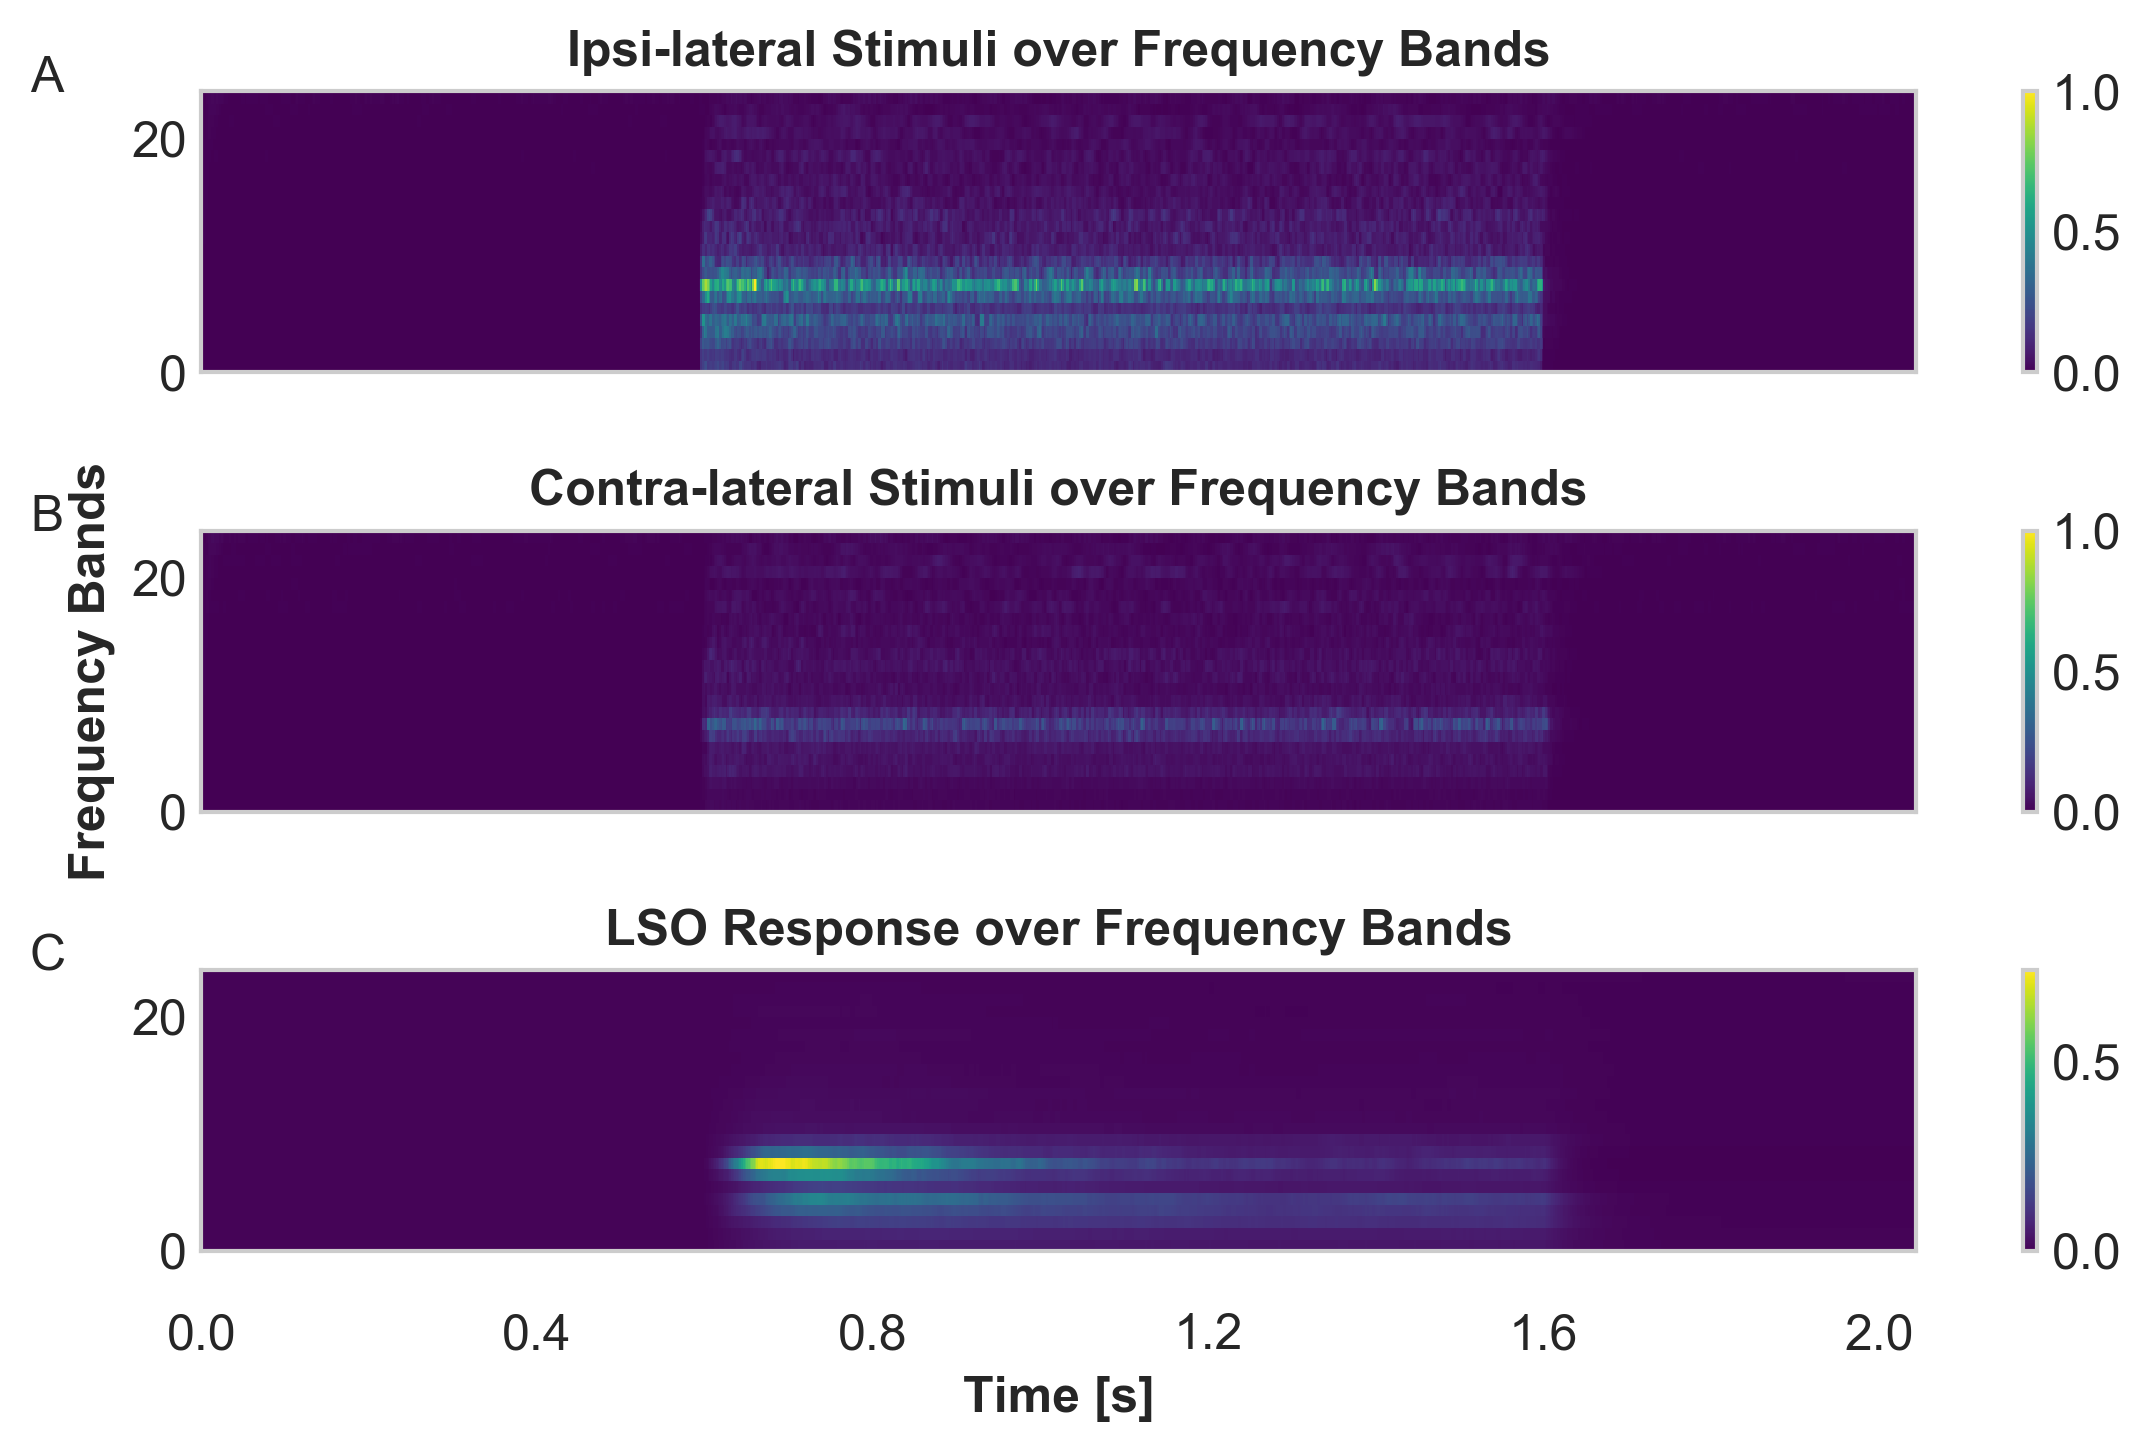

0.03728883727676811


In [14]:
fig = plt.figure()
# ax = plt.pcolor(s_sbc_all[:,:].T,cmap='viridis',vmin=0., vmax=1.)
ax = fig.add_subplot(311)
cb = ax.pcolormesh(s_sbc_all[:,:].T,cmap="viridis",linewidth=0,rasterized=True,vmin=0.,vmax=1.0)
plt.title('Ipsi-lateral Stimuli over Frequency Bands')
# plt.xlabel('Time [ms]')
ax.set_xticklabels(ax.get_xticks()/1000)
ax.get_xaxis().set_visible(False)
ax.annotate("A", xy=(-0.10, 1.0), xycoords="axes fraction",fontsize = 12)
# plt.ylabel('Frequency Bands')
plt.colorbar(cb)


ax = fig.add_subplot(312)
cb = ax.pcolormesh(s_gbc_all[:,:].T,cmap="viridis",linewidth=0,rasterized=True,vmin=0.,vmax=1.0)
plt.title('Contra-lateral Stimuli over Frequency Bands')
# plt.xlabel('Time [ms]')
ax.set_xticklabels(ax.get_xticks()/1000)
ax.get_xaxis().set_visible(False)
ax.annotate("B", xy=(-0.10, 1.0), xycoords="axes fraction",fontsize = 12)

plt.ylabel('Frequency Bands')
# ax.yaxis.labelpad = 20
plt.colorbar(cb)

ax = fig.add_subplot(313)
cb = ax.pcolormesh(g_r_out(r_all[0,:,:]).T,cmap="viridis",linewidth=0,rasterized=True,vmin=0)
plt.title('LSO Response over Frequency Bands')
plt.xlabel('Time [s]')
# plt.ylabel('Frequency Bands')
ax.annotate("C", xy=(-0.10, 1.0), xycoords="axes fraction",fontsize = 12)

ax.set_xticklabels(ax.get_xticks()*t_hop)
ax.tick_params(axis='x', which='major', pad=15)
plt.colorbar(cb)


plt.tight_layout()

plt.savefig(figure_name + 'all_freq_bands.svg')
plt.savefig(figure_name + 'all_freq_bands.pdf')
plt.savefig(figure_name + 'all_freq_bands.tiff')
plt.show()

input_level_diff = s_sbc_all[:,:].T  - s_gbc_all[:,:].T

print(np.mean(input_level_diff[:,:]))

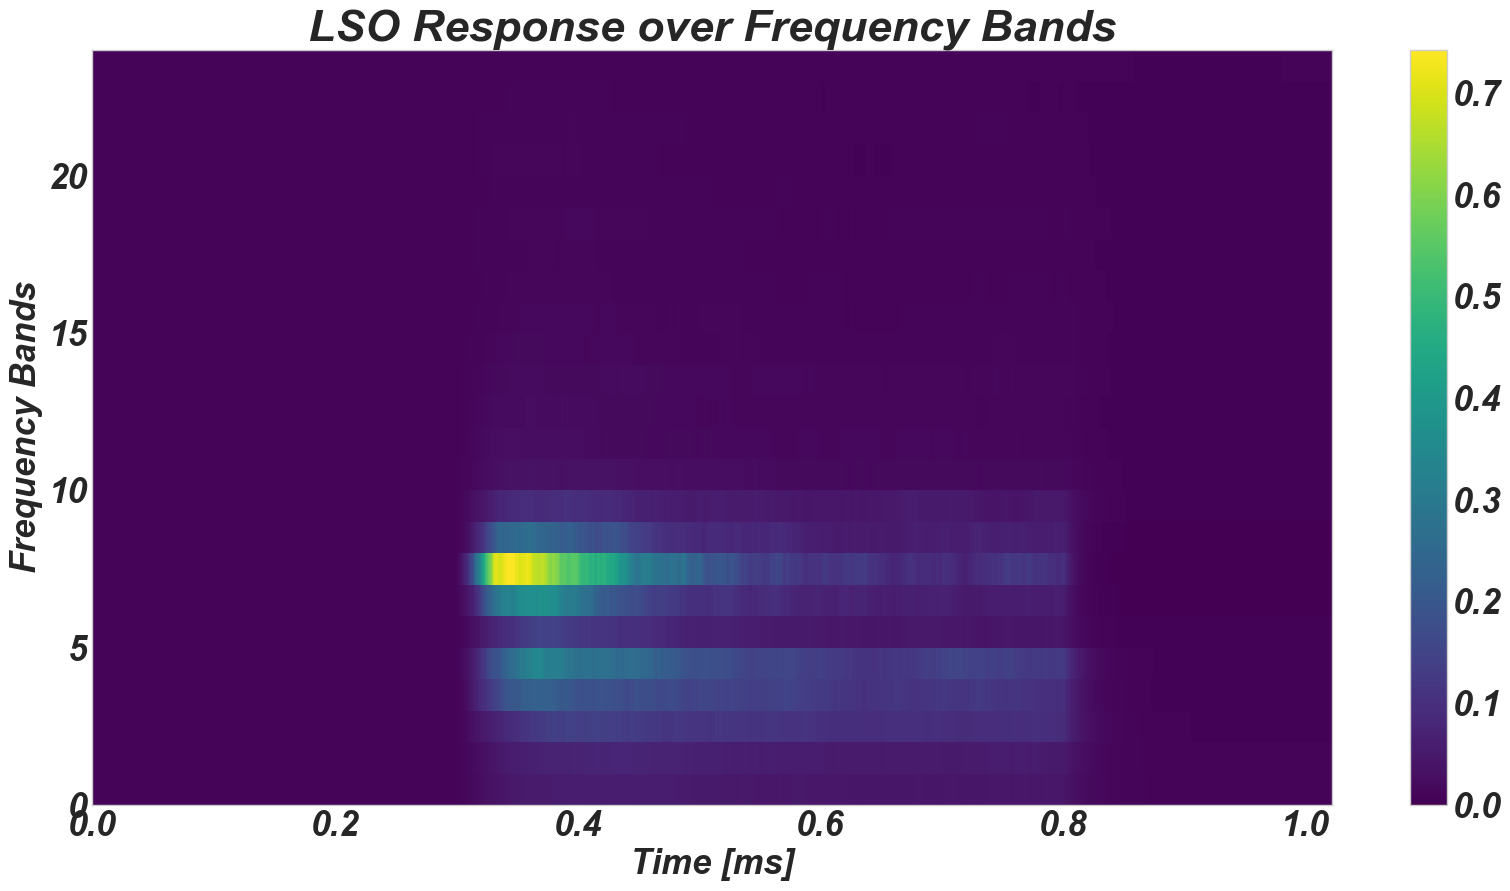

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
cb = ax.pcolormesh(g_r_out(r_all[0,:,:]).T,cmap="viridis",linewidth=0,rasterized=True,vmin=0)
plt.title('LSO Response over Frequency Bands')
plt.xlabel('Time [ms]')
ax.set_xticklabels(ax.get_xticks()/1000)
plt.ylabel('Frequency Bands')
plt.colorbar(cb)
# plt.savefig(figure_name + 'lso_freq_bands.svg')
# plt.savefig(figure_name + 'lso_freq_bands.pdf')

plt.show()

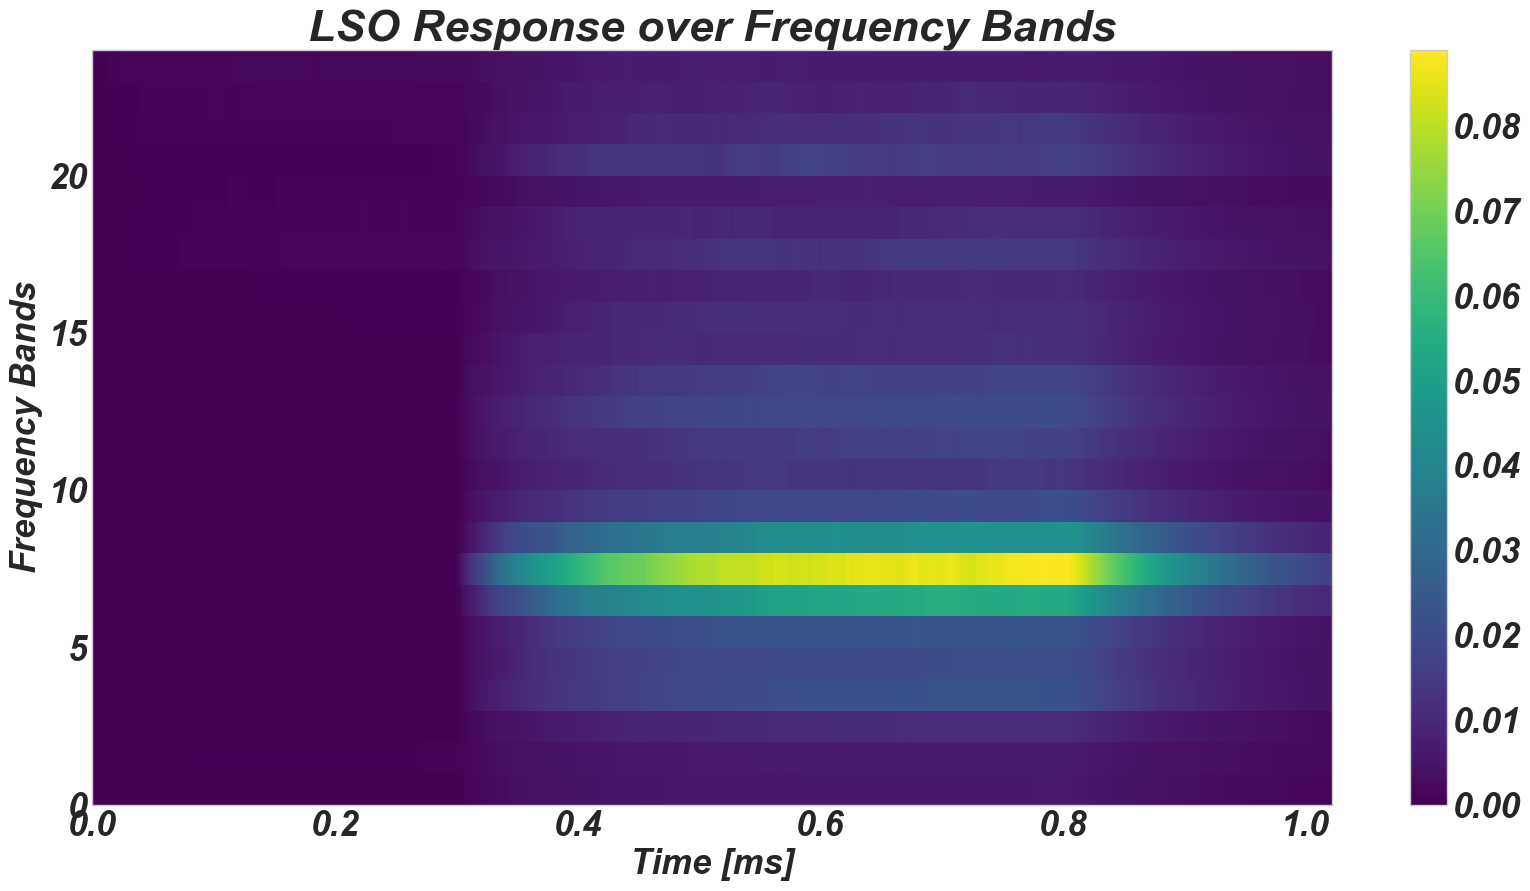

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
cb = ax.pcolormesh(q_all[0,:,:].T,cmap="viridis",linewidth=0,rasterized=True,vmin=0)
plt.title('LSO Response over Frequency Bands')
plt.xlabel('Time [ms]')
ax.set_xticklabels(ax.get_xticks()/1000)
plt.ylabel('Frequency Bands')
plt.colorbar(cb)
# plt.savefig(figure_name + 'lso_freq_bands.svg')
# plt.savefig(figure_name + 'lso_freq_bands.pdf')

plt.show()

#### When using t_window = 0.0002 (200us) we have a t_hop = 0.0001 which means that one column in the spectrogram represents 100us?. The onset of the two stimuli for -90 is 10 units apart. That mean there is an ITD of 1000us = 1ms . Does the model consider that ?